# **LIBRARY IMPORTS**

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,Conv2D
from IPython.display import display
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix
import itertools

# **IMAGE RESIZING AND TRAINING RATE**


In [2]:
warnings.filterwarnings('ignore')
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
TRAINING_RATE = 0.001

In [3]:

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

# **TRAINING AND TESTING DATASET LOADING**


In [4]:
train_datagen = ImageDataGenerator()
validate_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory(
            '/kaggle/input/datasetff/Datasets/train',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 15)

validation_set = validate_datagen.flow_from_directory(
            '/kaggle/input/datasetff/Datasets/test',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 15)

classes = {v: k for k, v in training_set.class_indices.items()}
classes

Found 39105 images belonging to 4 classes.
Found 6038 images belonging to 4 classes.


{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

# **XCPETION MODEL DEFINITION**


In [5]:

# Model
input_shape = INPUT_SHAPE
inputs = Input(input_shape)

# Xception
xception = Xception(include_top=False, input_shape=input_shape, weights='imagenet')(inputs)

# Output
outputs = GlobalAveragePooling2D()(xception)
outputs = Dropout(0.5)(outputs)
outputs = Dense(len(classes), activation='softmax')(outputs)

# Optimizer
opt1 = Adam(learning_rate=TRAINING_RATE)
opt2 = SGD(learning_rate=TRAINING_RATE)
opt3 = RMSprop(learning_rate=TRAINING_RATE)

Xmodel = Model(inputs, outputs)
Xmodel.compile(optimizer=opt1,
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall','AUC'])

Xmodel.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 20,815,148
Non-trai

# **RESNET MODEL DEFINITION**

In [6]:
input_tensor = Input(shape=INPUT_SHAPE)
res_net = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(res_net.output)
x = Dropout(0.5)(x)
outputs = Dense(len(training_set.class_indices), activation='softmax')(x)
Rmodel = Model(inputs=input_tensor, outputs=outputs)
Rmodel.compile(
    optimizer=SGD(learning_rate=TRAINING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy','Precision','Recall','AUC']
)

Rmodel.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

# **ENSEMBLE MODEL DEFINITION**

In [7]:
#Model
input_shape = INPUT_SHAPE
inputs = Input(input_shape)
input_tensor = Input(shape= (128,128,3))

#xception and resnet
xception = Xception(include_top=False, input_shape = input_shape, weights = 'imagenet')(inputs)
res_net = ResNet50(input_tensor = input_tensor, include_top = False, weights = 'imagenet')(inputs)

#output
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(res_net)])

outputs = Dropout(0.25)(outputs)
outputs = Dense(len(classes), activation='softmax')(outputs)

# Optimizer
opt1 = Adam(learning_rate=TRAINING_RATE)
opt2 = SGD(learning_rate=TRAINING_RATE)
opt3 =RMSprop(learning_rate=TRAINING_RATE)

model = Model(inputs, outputs)
model.compile(optimizer=opt2,
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall','AUC'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 4, 4, 2048)   20861480    ['input_4[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23587712    ['input_4[0][0]']                
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 2048)        0           ['xception[0][0]']         

# **ALL MODEL TRAINING**

In [8]:
Xception_model = Xmodel.fit(training_set,
                    steps_per_epoch=350,
                    epochs=10,
                    validation_data= validation_set,
                    validation_steps = len(validation_set))

Epoch 1/10
350/350 [==============================] - 129s 276ms/step - loss: 1.3156 - accuracy: 0.3520 - precision: 0.6372 - recall: 0.0756 - auc: 0.6327 - val_loss: 2.8550 - val_accuracy: 0.5081 - val_precision: 0.5270 - val_recall: 0.4886 - val_auc: 0.7614
Epoch 2/10
350/350 [==============================] - 57s 162ms/step - loss: 0.9181 - accuracy: 0.5825 - precision: 0.7151 - recall: 0.3724 - auc: 0.8476 - val_loss: 5.4669 - val_accuracy: 0.2652 - val_precision: 0.2459 - val_recall: 0.2069 - val_auc: 0.5472
Epoch 3/10
350/350 [==============================] - 52s 147ms/step - loss: 0.7716 - accuracy: 0.6478 - precision: 0.7163 - recall: 0.5198 - auc: 0.8904 - val_loss: 0.8621 - val_accuracy: 0.5959 - val_precision: 0.6085 - val_recall: 0.5778 - val_auc: 0.8874
Epoch 4/10
350/350 [==============================] - 51s 145ms/step - loss: 0.6394 - accuracy: 0.7211 - precision: 0.7580 - recall: 0.6537 - auc: 0.9268 - val_loss: 0.9322 - val_accuracy: 0.5994 - val_precision: 0.6136 - 

In [9]:
Resnet_model = Rmodel.fit(training_set,
                    steps_per_epoch= 350,
                    epochs=10,
                    validation_data= validation_set,
                    validation_steps = len(validation_set))

Epoch 1/10
350/350 [==============================] - 57s 121ms/step - loss: 1.3156 - accuracy: 0.4531 - precision: 0.5092 - recall: 0.3381 - auc: 0.7180 - val_loss: 0.9190 - val_accuracy: 0.5995 - val_precision: 0.6535 - val_recall: 0.5038 - val_auc: 0.8509
Epoch 2/10
350/350 [==============================] - 40s 113ms/step - loss: 0.9209 - accuracy: 0.6032 - precision: 0.6612 - recall: 0.5171 - auc: 0.8539 - val_loss: 0.7391 - val_accuracy: 0.6678 - val_precision: 0.7307 - val_recall: 0.5629 - val_auc: 0.8991
Epoch 3/10
350/350 [==============================] - 40s 113ms/step - loss: 0.7896 - accuracy: 0.6516 - precision: 0.7072 - recall: 0.5870 - auc: 0.8908 - val_loss: 0.5781 - val_accuracy: 0.7372 - val_precision: 0.7771 - val_recall: 0.6827 - val_auc: 0.9372
Epoch 4/10
350/350 [==============================] - 40s 114ms/step - loss: 0.6619 - accuracy: 0.7156 - precision: 0.7563 - recall: 0.6592 - auc: 0.9216 - val_loss: 0.4780 - val_accuracy: 0.7912 - val_precision: 0.8123 - v

In [10]:
Final_model = model.fit(training_set,
                    steps_per_epoch=2000 ,
                    epochs=10,
                    validation_data= validation_set,
                    validation_steps = len(validation_set))

Epoch 1/10
2000/2000 [==============================] - 363s 169ms/step - loss: 0.7690 - accuracy: 0.6608 - precision: 0.7502 - recall: 0.5569 - auc: 0.8938 - val_loss: 0.2952 - val_accuracy: 0.8980 - val_precision: 0.9172 - val_recall: 0.8764 - val_auc: 0.9874
Epoch 2/10
2000/2000 [==============================] - 337s 168ms/step - loss: 0.3324 - accuracy: 0.8716 - precision: 0.8936 - recall: 0.8481 - auc: 0.9808 - val_loss: 0.1685 - val_accuracy: 0.9344 - val_precision: 0.9370 - val_recall: 0.9316 - val_auc: 0.9945
Epoch 3/10
2000/2000 [==============================] - 336s 168ms/step - loss: 0.1603 - accuracy: 0.9431 - precision: 0.9504 - recall: 0.9357 - auc: 0.9954 - val_loss: 0.0270 - val_accuracy: 0.9942 - val_precision: 0.9949 - val_recall: 0.9937 - val_auc: 0.9999
Epoch 4/10
2000/2000 [==============================] - 336s 168ms/step - loss: 0.0951 - accuracy: 0.9686 - precision: 0.9718 - recall: 0.9647 - auc: 0.9983 - val_loss: 0.0149 - val_accuracy: 0.9970 - val_precision

In [11]:
model.save("FModel.h5")

In [12]:
accuracy_scores = {
    'ResNet50': {'Train Acc': Resnet_model.history['accuracy'][-1],
                 'Val Acc': Resnet_model.history['val_accuracy'][-1],
                 'Precision': Resnet_model.history['precision'][-1],
                 'Recall': Resnet_model.history['recall'][-1],
                 'Auc': Resnet_model.history['auc'][-1]
                },
    'Xception': {'Train Acc': Xception_model.history['accuracy'][-1],
                 'Val Acc': Xception_model.history['val_accuracy'][-1],
                 'Precision': Xception_model.history['precision'][-1],
                 'Recall': Xception_model.history['recall'][-1],
                 'Auc': Xception_model.history['auc'][-1]
                },
    'Ensemble': {'Train Acc': Final_model.history['accuracy'][-1],
                 'Val Acc': Final_model.history['val_accuracy'][-1],
                 'Precision': Final_model.history['precision'][-1],
                 'Recall': Final_model.history['recall'][-1],
                 'Auc': Final_model.history['auc'][-1]
                }
    
}


accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index')
display(accuracy_df)

,Train Acc,Val Acc,Precision,Recall,Auc
ResNet50,0.883238,0.942696,0.897987,0.866857,0.983576
Xception,0.919238,0.961245,0.928613,0.911810,0.990539
Ensemble,0.994767,0.999834,0.994932,0.994633,0.999925


# **VISUALIZATION**

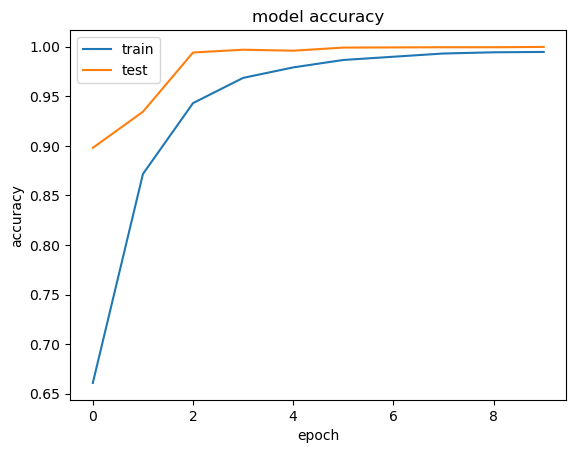

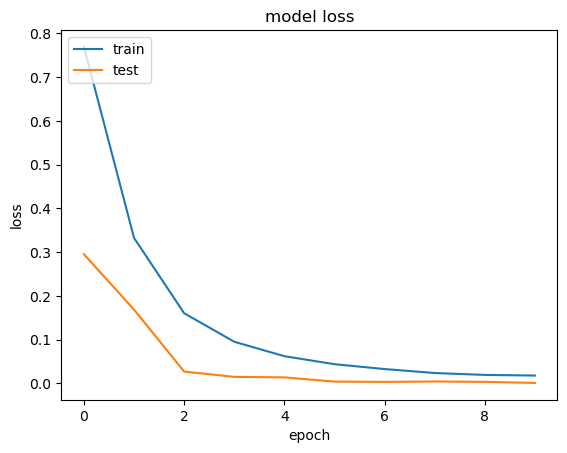

In [13]:
plt.plot(Final_model.history['accuracy'])
plt.plot(Final_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss graph
plt.plot(Final_model.history['loss'])
plt.plot(Final_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **CONFUSION MATRIX**

In [14]:
test_set = validate_datagen.flow_from_directory(
            '/kaggle/input/datasetff/Datasets/val',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 500)

Found 426 images belonging to 4 classes.


In [15]:
test_imgs, test_labels = next(test_set)
rounded_labels = np.argmax(test_labels, axis=-1)
test_model = load_model('/kaggle/working/FModel.h5')
predictions = test_model.predict_generator(test_set, steps = 1, verbose=0)
rounded_prediction = np.argmax(predictions, axis=-1)


In [16]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [17]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 85   0   0   0]
 [  0  64   0   0]
 [  0   0 141   0]
 [  0   0   0 136]]


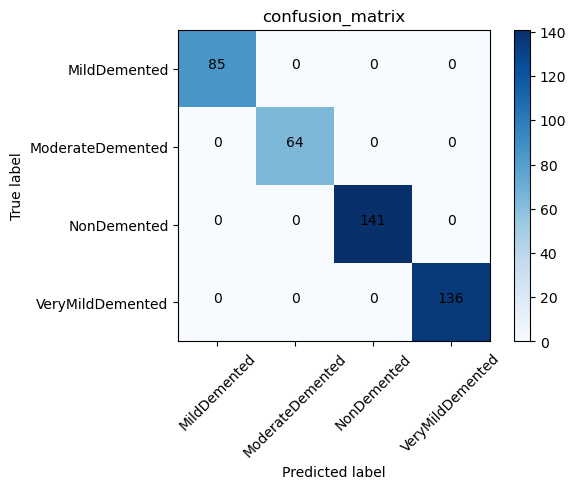

In [18]:
cm_plot_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')